In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import logging
import pandas as pd
import numpy as np
import math
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import shap
import joblib
import lime
from lime import lime_tabular
from lime import submodular_pick
import xgboost as xgb
from xgboost import XGBClassifier
from ltcn.LTCN import LTCN
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV,GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, cohen_kappa_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import optuna
from optuna.visualization.matplotlib import plot_optimization_history


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Supporting Functions

In [19]:
 # Function to assess Model performance
def conf_matrix_classif_report(model, y_test, y_pred_val):
  """
  model : str variable with model name to be used for titles.
  y_test : Variable with True label list
  y_pred_val : Variable with Model predicted values.
  """

  # Target classes
  class_label = ['3','4','5']

  # Model primary metric: f1 macro score
  model_f1_macro_score= f1_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} f1 macro score: {model_f1_macro_score}")

  # Model support metric: precision macro score
  model_precision_macro_score = precision_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} precision macro score: {model_precision_macro_score}")

  # Model support metric: recall macro score
  model_recall_macro_score = recall_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} recall macro score: {model_recall_macro_score}")

   # Model support metric: balanced accuracy score
  model_balanced_accuracy_score= balanced_accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} balanced accuracy score: {model_balanced_accuracy_score}")

   # Model support metric: accuracy score
  model_accuracy_score= accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} accuracy score: {model_accuracy_score}")

  # Model support metric: cohen kappa score
  model_cohen_kappa_score= cohen_kappa_score(y_test, y_pred_val)
  print('')
  print(f"{model} cohen kappa score: {model_cohen_kappa_score}")

  # Classification report
  classif_report = classification_report(y_test, y_pred_val)
  print('')
  print(f"Classification Report:\n\n{classif_report}")
  print('')
  
  # Confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred_val)
  sns.set(font_scale=1.2) 
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  tick_pos = np.arange(len(class_label)) + 0.5
  plt.xticks(tick_pos, class_label)
  plt.yticks(tick_pos, class_label)
  plt.title(f"Confusion Matrix: {model}")
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

In [61]:
# ROC AUC Score function
def roc_curves(model,y_train, y_test, y_pred):
    # Reshape target label
    y_train_reshaped_ohe = y_train.reshape(-1, 1)
    y_test_reshaped_ohe = y_test.reshape(-1, 1)
    y_pred_reshaped_ohe = y_pred.reshape(-1, 1)

    # OneHotEncode reshaped target label 
    ohe  = OneHotEncoder(sparse=False, handle_unknown='ignore')
    y_train_ohe = ohe.fit_transform(y_train_reshaped_ohe)
    y_test_ohe = ohe.transform(y_test_reshaped_ohe)
    y_pred_ohe = ohe.transform(y_pred_reshaped_ohe)

    # Compute ROC cuver and calculate AUC score 
    for i in range(y_train_ohe.shape[1]):
      fpr, tpr, _ = roc_curve(y_test_ohe[:,i], y_pred_ohe[:,i]) # Compute ROC curve for the current class
      auc_score = roc_auc_score(y_test_ohe[:,i], y_pred_ohe[:,i]) # Calculate AUC score for the ROC curve
      # Plot ROC curve and class label together with AUC
      plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='-',color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model} - ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

In [3]:
# Load file paths
full_dataset = "add_path_to_final_dataset"

In [4]:
# Load datasets
bike_full_df = pd.read_csv(full_dataset, header = 0, sep = ';')
print(bike_full_df.shape)

(2035394, 43)


Step to test predicting only 3 groups

In [5]:
# Removing Unknown ageRange: 0  from dataset
bike_full_df = bike_full_df[bike_full_df['ageRange'].isin([3,4,5])]

print(bike_full_df.shape)
print(bike_full_df.dtypes)

(1991440, 43)
_id                           object
user_day_code                 object
idplug_base                    int64
user_type                      int64
idunplug_base                  int64
travel_time                    int64
idunplug_station               int64
ageRange                       int64
idplug_station                 int64
unplug_hourTime               object
zip_code                      object
temp_unplug_hourTime          object
year                           int64
month                          int64
day                            int64
hour                           int64
travel_time_min              float64
travel_revenue               float64
id_weather                     int64
80                           float64
81                           float64
82                           float64
83                           float64
86                           float64
87                           float64
88                           float64
89                      

In [6]:
bike_full_df['ageRange'].unique()

array([5, 3, 4], dtype=int64)

In [7]:
# Removing Outliers:
all_instances = bike_full_df['ageRange'].value_counts()
all_instances

ageRange
4    1053275
5     745857
3     192308
Name: count, dtype: int64

In [8]:
# Removing Outliers (Set up threshold):
bike_full_df = bike_full_df[bike_full_df['travel_time_min']<=30]
display(bike_full_df['ageRange'].value_counts())
print(1-(bike_full_df.shape[0]/1991443))
1-(bike_full_df['ageRange'].value_counts()/all_instances)


ageRange
4    1014110
5     709982
3     181401
Name: count, dtype: int64

0.04315965859931714


ageRange
4    0.037184
5    0.048099
3    0.056716
Name: count, dtype: float64

## Feature Selection

In [9]:
bike_full_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'ageRange', 'idplug_station',
       'unplug_hourTime', 'zip_code', 'temp_unplug_hourTime', 'year', 'month',
       'day', 'hour', 'travel_time_min', 'travel_revenue', 'id_weather', '80',
       '81', '82', '83', '86', '87', '88', '89', 'date', 'week_day',
       'WorkingDay_Holiday_Sunday', 'holiday_type', 'holiday_desc',
       'day_of_week', 'unplug_station_tot_bases', 'idunplug_latitude',
       'idunplug_longitude', 'plug_station_tot_bases', 'idplug_latitude',
       'idplug_longitude', 'mh_distance_meters', 'time_group',
       'unique_user_day_code', 'tot_trips_day'],
      dtype='object')>

In [10]:
# Feature selection
bike_full_df.columns.to_list
selected_columns = [
    #'idplug_base', 
    #'idunplug_base',
    'travel_time', 
    #'idunplug_station', # Replaced with idunplug_latitude / longitude
    'idunplug_latitude',
    'idunplug_longitude',
    'unplug_station_tot_bases',
    'ageRange', 
    #'idplug_station', # Replaced with iduplug_latitude / longitude
    'idplug_latitude',
    'idplug_longitude',
    'plug_station_tot_bases',
    #'unplug_hourTime', 
    #'zip_code',
    #'year', 
    'month',
    'day', 
    'hour',
    'time_group', 
    'travel_revenue',
    'tot_trips_day',
    'mh_distance_meters', 
    #'80', # Contains NaN Values
    '81', 
    '82', 
    '83', 
    '86', 
    '87', 
    '88', 
    '89',
    'day_of_week',
    #'WorkingDay_Holiday_Sunday', 
    'holiday_type' 
    #'holiday_desc',
       ]


filter_bike_df = bike_full_df[selected_columns]
print(filter_bike_df.dtypes)
display(filter_bike_df.head())

print(f"Present NA values: {filter_bike_df.isna().sum()}")

travel_time                   int64
idunplug_latitude           float64
idunplug_longitude          float64
unplug_station_tot_bases      int64
ageRange                      int64
idplug_latitude             float64
idplug_longitude            float64
plug_station_tot_bases        int64
month                         int64
day                           int64
hour                          int64
time_group                    int64
travel_revenue              float64
tot_trips_day                 int64
mh_distance_meters          float64
81                          float64
82                          float64
83                          float64
86                          float64
87                          float64
88                          float64
89                          float64
day_of_week                   int64
holiday_type                 object
dtype: object


travel_time  idunplug_latitude  idunplug_longitude  \
0          415          40.403408           -3.710811   
1          417          40.424846           -3.673863   
2          448          40.404785           -3.702827   
3          468          40.422658           -3.687055   
4          149          40.417924           -3.670896   

   unplug_station_tot_bases  ageRange  idplug_latitude  idplug_longitude  \
0                        24         5        40.415010         -3.706103   
1                        24         3        40.444226         -3.678717   
2                        24         4        40.413885         -3.704941   
3                        24         5        40.429887         -3.671282   
4                        24         4        40.421398         -3.675204   

   plug_station_tot_bases  month  day  hour  time_group  travel_revenue  \
0                      18      1    1     0           0             0.5   
1                      18      1    1     0           0             0.5   
2                      24      1    1     0           0             0.5   
3                      24      1    1     0           0             0.5   
4                      24      1    1     0           0             0.5   

   tot_trips_day  mh_distance_meters    81    82   83    86     87     88  \
0              1         1760.389172  0.69  22.0  4.4  67.0  957.0  101.0   
1              1         2641.794256  0.69  22.0  4.4  67.0  957.0  101.0   
2              1         1221.373443  0.69  22.0  4.4  67.0  957.0  101.0   
3              1         2405.058377  0.69  22.0  4.4  67.0  957.0  101.0   
4              1          821.854857  0.69  22.0  4.4  67.0  957.0  101.0   

    89  day_of_week      holiday_type  
0  0.0            1  national_holiday  
1  0.0            1  national_holiday  
2  0.0            1  national_holiday  
3  0.0            1  national_holiday  
4  0.0            1  national_holiday

Present NA values: travel_time                 0
idunplug_latitude           0
idunplug_longitude          0
unplug_station_tot_bases    0
ageRange                    0
idplug_latitude             0
idplug_longitude            0
plug_station_tot_bases      0
month                       0
day                         0
hour                        0
time_group                  0
travel_revenue              0
tot_trips_day               0
mh_distance_meters          0
81                          0
82                          0
83                          0
86                          0
87                          0
88                          0
89                          0
day_of_week                 0
holiday_type                0
dtype: int64


## Train, test split

In [11]:
# Set up random state for reproducible results
rand_state = 123

# Set up number of folds for cross validation:
numb_split = 5

In [12]:
# Train, test split stratify based on ageRange
train, test = train_test_split(filter_bike_df, stratify=filter_bike_df["ageRange"],test_size=0.20, random_state=rand_state)

In [13]:
# Splitting target vs independent variables
X_train = train.drop("ageRange", axis=1)
y_train = train["ageRange"].values

X_test = test.drop("ageRange", axis=1)
y_test = test["ageRange"].values

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train length: {len(y_train)}")
print("")
print(f"X_test shape: {X_test.shape}")
print(f"y_test length: {len(y_test)}")

X_train shape: (1524394, 23)
y_train length: 1524394

X_test shape: (381099, 23)
y_test length: 381099


## Common Pre-processing steps

In [15]:
# Common Preprocessing steps:
featurizer = ColumnTransformer(
    transformers=[
        ('one_hot_en',OneHotEncoder(sparse=False, handle_unknown='ignore'),['holiday_type'
                                                                            ]),
        ('normalization',MinMaxScaler(),['travel_time',
                                         'idunplug_latitude',
                                         'idunplug_longitude',
                                         'unplug_station_tot_bases',
                                         'idplug_latitude',
                                         'idplug_longitude',
                                         'plug_station_tot_bases',
                                         'tot_trips_day',
                                         'travel_revenue',
                                         'mh_distance_meters',
                                         '81',
                                         '82',
                                         '83',
                                         '86',
                                         '87',
                                         '88',
                                         '89'
                                            ]
                                            )                                        
                ],
                                                remainder='passthrough')

In [16]:
X_train_trans  = featurizer.fit_transform(X_train)
X_test_trans = featurizer.transform(X_test)
display(X_train_trans[[0],])
X_train_trans.shape

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        0.54196776, 0.5850373 , 0.43096397, 0.66666667, 0.40579311,
        0.42176765, 0.66666667, 0.05263158, 0.25      , 0.15410796,
        0.15849057, 0.        , 0.86879433, 0.21052632, 0.64864865,
        0.68548387, 0.        , 9.        , 3.        , 6.        ,
        0.        , 1.        ]])

(1524394, 27)

In [17]:
# Label encode for Base RFC estimators & XGBClassifier {3:0, 4:1, 5:2}
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

## Baseline DummyClassifier (Majority Class)

In [19]:
dummy_clf = DummyClassifier(strategy="most_frequent")


majority = make_pipeline(featurizer,dummy_clf)
majority.fit(X_train, y_train)

majority_pred = majority.predict(X_test)

In [20]:
dummy_f1_macro_score = f1_score(y_test, majority_pred, average='macro')
dummy_f1_score = f1_score(y_test, majority_pred, average=None)

print(f"DummyClassifier F1 macro score: {dummy_f1_macro_score}")
print(f"DummyClassifier F1 score: {dummy_f1_score}")

DummyClassifier F1 macro score: 0.2315632879561904
DummyClassifier F1 score: [0.         0.69468986 0.        ]



Dummy Classifier f1 macro score: 0.2315632879561904

Dummy Classifier precision macro score: 0.1774009728005934

Dummy Classifier recall macro score: 0.3333333333333333

Dummy Classifier balanced accuracy score: 0.3333333333333333

Dummy Classifier accuracy score: 0.5322029184017801

Dummy Classifier cohen kappa score: 0.0

Classification Report:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00     36280
           4       0.53      1.00      0.69    202822
           5       0.00      0.00      0.00    141997

    accuracy                           0.53    381099
   macro avg       0.18      0.33      0.23    381099
weighted avg       0.28      0.53      0.37    381099




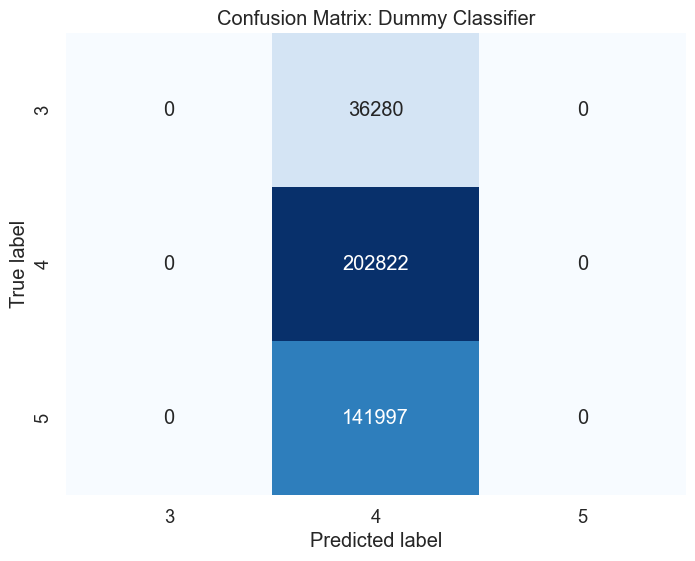

In [24]:
# Dummy Classifier Test performance
conf_matrix_classif_report("Dummy Classifier", y_test, majority_pred)

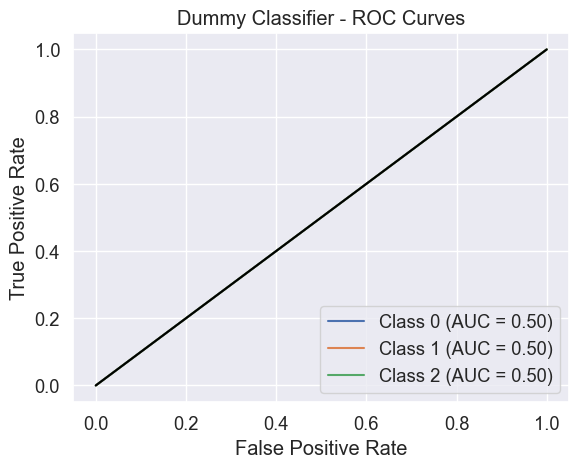

In [62]:
roc_curves("Dummy Classifier", y_train, y_test, majority_pred)

## Baseline Logistic Regression

### Baseline Logit 

In [20]:
numb_split = 5
rand_state = 123

# Create logistic regression model
base_logit_cv = LogisticRegression(multi_class='ovr', random_state=rand_state)

# Define the StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Measure traininig time
start_time = time.time()
cv_results = cross_validate(base_logit_cv, X_train_trans, y_train, cv=stratified_kfold, scoring=f1_scorer, return_train_score=True)
end_time = time.time()
base_logit_train_time = end_time - start_time

In [ ]:
# Print the cross-validation training time and scores:
print(f"Base logit training time: {base_logit_train_time} seconds for K-fold: {numb_split}\n")

In [22]:
# Train performance
print(f"Base Logit Cross-val Mean f1 macro train_score: {np.mean(cv_results['train_score'])}")
print(f"Base Logit Cross-val Standard Deviation of f1 macro train_score: {np.std(cv_results['train_score'])}\n")

Base Logit Cross-val Mean f1 macro train_score: 0.25293052234509855
Base Logit Cross-val Standard Deviation of f1 macro train_score: 0.0007550040638160047



In [23]:
# Validation performance
print(f"Base Logit Cross-val Mean f1 macro val_score: {np.mean(cv_results['test_score'])}")
print(f"Base Logit Cross-val Standard Deviation of f1 macro val_score: {np.std(cv_results['test_score'])}")

Base Logit Cross-val Mean f1 macro val_score: 0.25285838616209677
Base Logit Cross-val Standard Deviation of f1 macro val_score: 0.0007317768713761314


### Baseline Logit Test performance

In [50]:
# Create baseline logistic regression model
base_logit = LogisticRegression(multi_class='ovr',random_state=rand_state)

# Fit model with entire training dataset
base_logit.fit(X_train_trans,y_train)

# Make predictions on the test dataset
base_logit_prediction = base_logit.predict(X_test_trans)


Base Logit f1 macro score: 0.25340303162255745

Base Logit precision macro score: 0.33588020618804076

Base Logit recall macro score: 0.3378723858536495

Base Logit balanced accuracy score: 0.3378723858536495

Base Logit accuracy score: 0.5335490253188804

Base Logit cohen kappa score: 0.012703710606088547

Classification Report:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00     36280
           4       0.54      0.98      0.69    202822
           5       0.47      0.04      0.07    141997

    accuracy                           0.53    381099
   macro avg       0.34      0.34      0.25    381099
weighted avg       0.46      0.53      0.39    381099




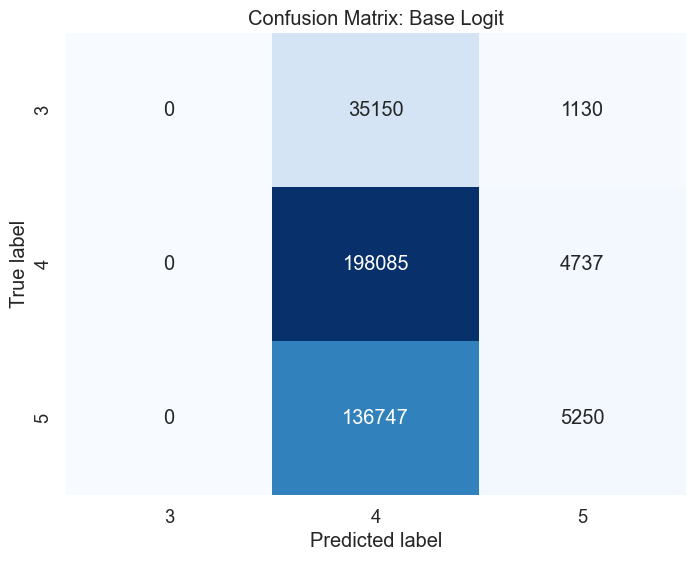

In [51]:
# Test performance
conf_matrix_classif_report("Base Logit", y_test, base_logit_prediction)

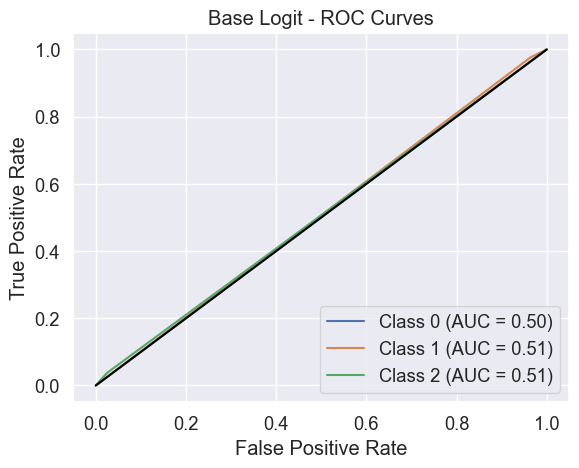

In [63]:
# Test performance
roc_curves("Base Logit", y_train, y_test, base_logit_prediction) 

## Baseline RandomForestClassifier

### Baseline RFC

In [26]:
numb_split = 5
rand_state = 123

# Define Base RandomForestClassifier model
base_rfc_cv = RandomForestClassifier(random_state=rand_state, n_jobs=-1)

# Define the StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Measure traininig time
start_time = time.time()
base_rfc_cv_results = cross_validate(base_rfc_cv, X_train_trans, y_train, cv=stratified_kfold, scoring=f1_scorer, return_train_score=True, return_estimator=True)
end_time = time.time()
base_rfc_train_time = end_time - start_time

In [ ]:
# Print the cross-validation training time and scores:
print(f"Base RFC training time: {base_rfc_train_time} seconds for K-fold: {numb_split}\n")

In [28]:
# Train performance
print(f"Base RFC Cross-val Mean f1 macro train_score: {np.mean(base_rfc_cv_results['train_score'])}")
print(f"Base RFC Cross-val Standard Deviation of f1 macro train_score: {np.std(base_rfc_cv_results['train_score'])}\n")

Base RFC Cross-val Mean f1 macro train_score: 0.999962515803337
Base RFC Cross-val Standard Deviation of f1 macro train_score: 2.24424043105012e-06



In [29]:
# Validation performance
print(f"Base RFC Cross-val Mean f1 macro val_score: {np.mean(base_rfc_cv_results['test_score'])}")
print(f"Base RFC Cross-val Standard Deviation of f1 macro val_score: {np.std(base_rfc_cv_results['test_score'])}")

Base RFC Cross-val Mean f1 macro val_score: 0.5867205585972153
Base RFC Cross-val Standard Deviation of f1 macro val_score: 0.0007745366451964638


#### Plot max_depth for base cross validated models

In [30]:
# base rfc cv max depth parameters:
cv_max_depth = []


for val in base_rfc_cv_results['estimator']:
    for estimator in val.estimators_:
        # Extract maximum depth of the tree
        cv_max_depth.append(estimator.tree_.max_depth)
        

# Create a pandas DataFrame to store the information
cv_data_test = {'cv_max_depth': cv_max_depth}
cv_tree_performance_df = pd.DataFrame(cv_data_test)
display(cv_tree_performance_df["cv_max_depth"].value_counts())

print(f"Minimum depth of trees in RandomForestClassifier cross validation: {cv_tree_performance_df["cv_max_depth"].min()}")
print(f"Maximum depth of trees in RandomForestClassifier cross validation: {cv_tree_performance_df["cv_max_depth"].max()}")
print(f"Average depth of trees in RandomForestClassifier: {cv_tree_performance_df["cv_max_depth"].mean()}")

cv_max_depth
54    92
56    69
53    66
52    62
55    58
57    38
58    35
51    22
59    19
60    15
50    11
61     5
49     2
62     2
64     2
67     1
63     1
Name: count, dtype: int64

Minimum depth of trees in RandomForestClassifier cross validation: 49
Maximum depth of trees in RandomForestClassifier cross validation: 67
Average depth of trees in RandomForestClassifier: 54.836


In [31]:
print(f"Minimum depth of trees in RandomForestClassifier cross validation: {cv_tree_performance_df["cv_max_depth"].min()}")
print(f"Maximum depth of trees in RandomForestClassifier cross validation: {cv_tree_performance_df["cv_max_depth"].max()}")
print(f"Average depth of trees in RandomForestClassifier: {cv_tree_performance_df["cv_max_depth"].mean()}")

Minimum depth of trees in RandomForestClassifier cross validation: 49
Maximum depth of trees in RandomForestClassifier cross validation: 67
Average depth of trees in RandomForestClassifier: 54.836


### Baseline RFC Test performance

In [18]:
numb_split = 5
rand_state = 123

# Define Base RandomForestClassifier model
base_rfc = RandomForestClassifier(random_state=rand_state, n_jobs=-1)

# Fit model with entire training dataset
base_rfc.fit(X_train_trans,y_train)

# Make predictions on the test dataset
base_rfc_prediction = base_rfc.predict(X_test_trans)


Base RFC f1 macro score: 0.6089989307067979

Base RFC precision macro score: 0.7521702229657219

Base RFC recall macro score: 0.5757260251693701

Base RFC balanced accuracy score: 0.5757260251693701

Base RFC accuracy score: 0.7109307555254671

Base RFC cohen kappa score: 0.4528401597067916

Classification Report:

              precision    recall  f1-score   support

           3       0.82      0.26      0.40     36280
           4       0.69      0.88      0.77    202822
           5       0.74      0.59      0.65    141997

    accuracy                           0.71    381099
   macro avg       0.75      0.58      0.61    381099
weighted avg       0.72      0.71      0.69    381099




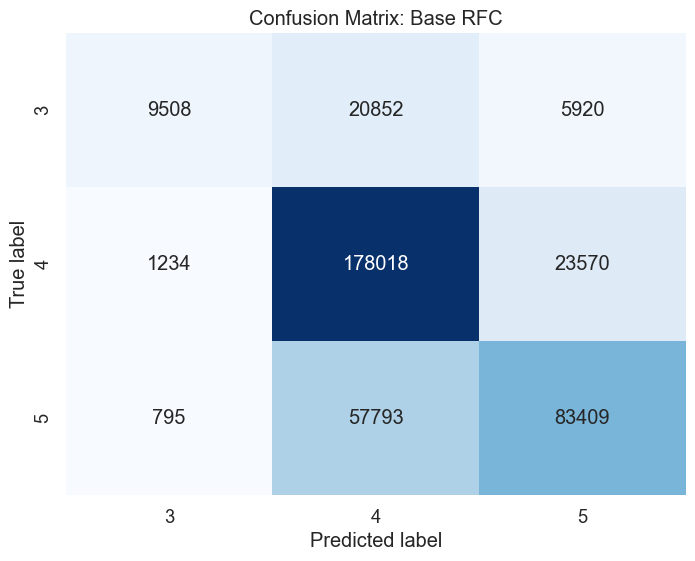

In [20]:
# Test performance
conf_matrix_classif_report("Base RFC", y_test, base_rfc_prediction)

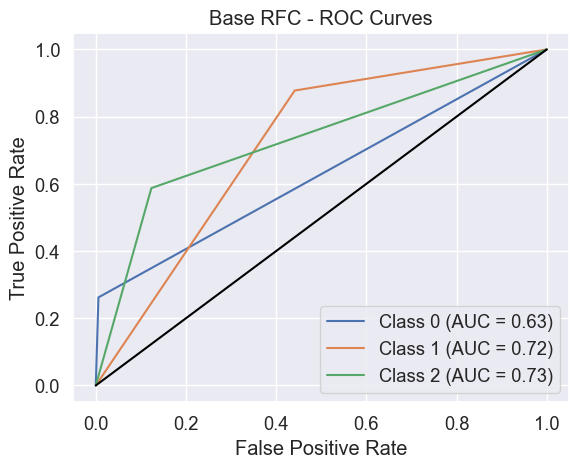

In [66]:
# Test performance
roc_curves("Base RFC", y_train, y_test, base_rfc_prediction) 

### SHAP Feature Importance


   


In [21]:
rfc_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

In [22]:
X_test_trans[5]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.34741523,  0.62838952,  0.38238132,  0.66666667,  0.81780077,
        0.37099912,  0.66666667,  0.10526316,  0.25      ,  0.16405174,
        0.84716981,  0.60055866,  0.29787234,  0.90789474,  0.21621622,
        0.20967742,  0.03571429,  1.        , 31.        , 13.        ,
        2.        ,  3.        ])

In [43]:
# Select stratified sample size
sub_X_train_bad, sub_X_test, sub_y_train_bad, sub_y_test = train_test_split(X_test_trans, y_test, test_size = 0.0008, stratify=y_test, random_state = rand_state)

In [44]:
print(sub_y_test.shape)
sub_X_test.shape


(305,)


(305, 27)

In [45]:
# Summarize data using k-means due to computational limitations
summary_test_background = shap.kmeans(sub_X_test, 3)

# Create an explainer using SHAP Kernel with summarize sub_test data
kernel_explainer = shap.KernelExplainer(base_rfc.predict,summary_test_background)

# Compute SHAP valuse for the test data:
shap_val_test_kernel = kernel_explainer.shap_values(sub_X_test)

100%|██████████| 305/305 [01:13<00:00,  4.18it/s]


In [34]:
# Display random selected samples:
y_shap_sub_test = pd.DataFrame(sub_y_test)
y_shap_sub_test.value_counts()

0
4    203
5    142
3     37
Name: count, dtype: int64

In [38]:
y_shap_sub_test[0]==3

0      False
1      False
2      False
3      False
4      False
       ...  
195    False
196     True
197    False
198    False
199    False
Name: 0, Length: 200, dtype: bool

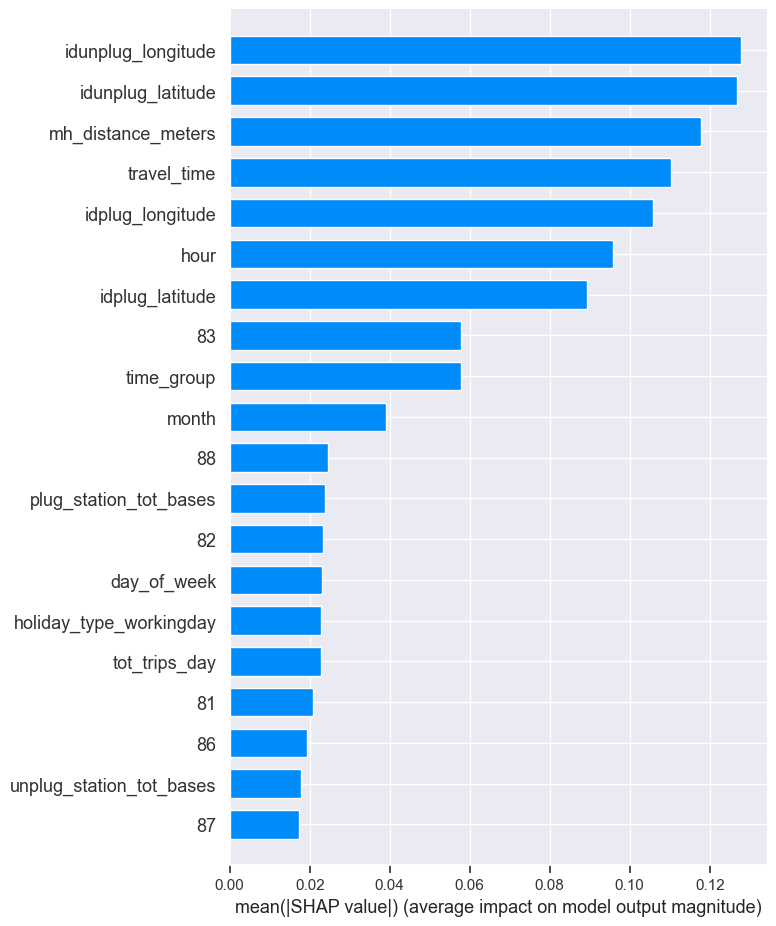

In [46]:
# Plot Shap Values Feature importance
shap.summary_plot(shap_val_test_kernel, feature_names=rfc_feature_names, plot_type='bar')

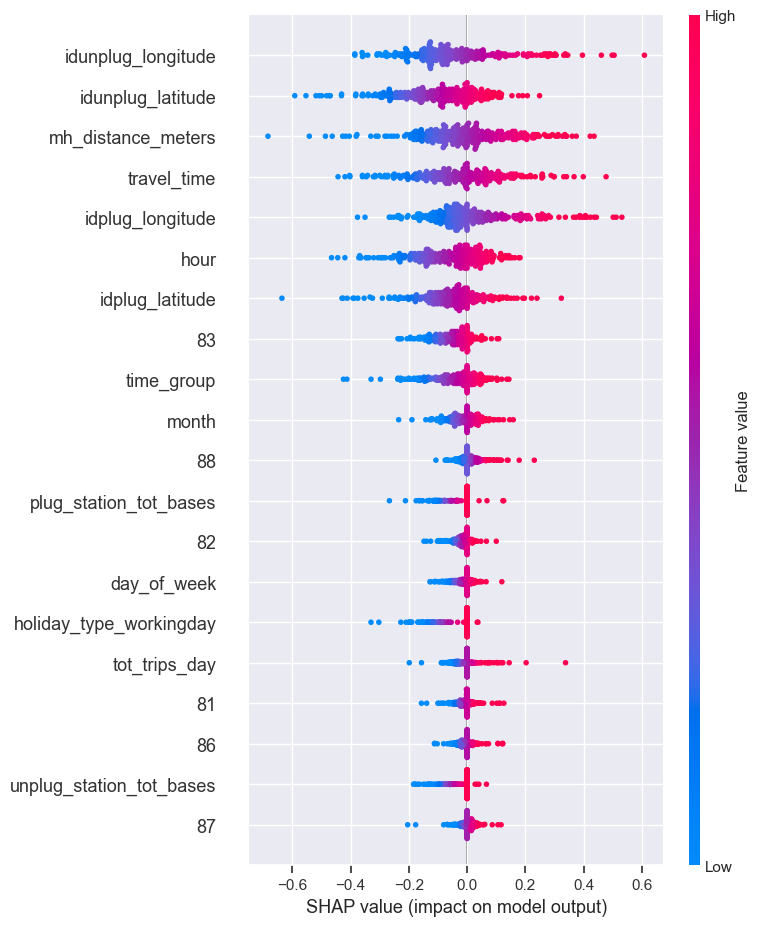

In [47]:
# Plot the aggregated SHAP values for the top ten features 
shap.summary_plot(shap_val_test_kernel,features=shap_val_test_kernel, feature_names=rfc_feature_names)

## Performance degradation:

In [69]:
feat_impo_test = pd.DataFrame(X_test_trans, columns=rfc_feature_names)
display(feat_impo_test.head())

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

### Calculate SHAP Feature Importance 

In [ ]:
# Calculate mean values from shap_values to extract most important feature list
vals_shap = np.abs(shap_val_test_kernel).mean(0)
vals_shap

# Store shap feature importance values in dataframe
feature_importance = pd.DataFrame(list(zip(rfc_feature_names, vals_shap)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

array([2.00104842e-05, 4.58800523e-05, 2.22462398e-04, 6.02532625e-03,
       2.29266662e-02, 1.10388596e-01, 1.26914728e-01, 1.27877349e-01,
       1.77940444e-02, 8.92137988e-02, 1.05723494e-01, 2.39184462e-02,
       2.27628858e-02, 5.45077803e-04, 1.17812858e-01, 2.09029145e-02,
       2.32643640e-02, 5.79220342e-02, 1.94486098e-02, 1.74497493e-02,
       2.45709016e-02, 1.29495734e-02, 3.91843736e-02, 1.73737162e-02,
       9.58167973e-02, 5.78510270e-02, 2.30787679e-02])

In [ ]:
# List Feature importance order desc
rows_list_full = []
for index, row in feature_importance.iterrows():
    rows_list_full.append(row['col_name'])
rows_list_full

['idunplug_longitude',
 'idunplug_latitude',
 'mh_distance_meters',
 'travel_time',
 'idplug_longitude',
 'hour',
 'idplug_latitude',
 '83',
 'time_group',
 'month',
 '88',
 'plug_station_tot_bases',
 '82',
 'day_of_week',
 'holiday_type_workingday',
 'tot_trips_day',
 '81',
 '86',
 'unplug_station_tot_bases',
 '87',
 'day',
 '89',
 'holiday_type_weekend',
 'travel_revenue',
 'holiday_type_national_holiday',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_local_holiday_in_the_city_of_madrid']

### Support transformations Feature Importance Marginalization

In [76]:
test_asdf = feat_impo_test.copy(deep=True)

# Feature performance idunplug_station pairwise mode calculation
# Replace the values from df columns named 'idunplug_latitude' and 'idunplug_longitude' by mode
mode_value_lat = test_asdf['idunplug_latitude'].mode()[0]  # Calculate mode
test_asdf['idunplug_latitude'] = mode_value_lat

mode_value_lon = test_asdf['idunplug_longitude'].mode()[0]  # Calculate mode
test_asdf['idunplug_longitude'] = mode_value_lon


display(test_asdf.head())
display(feat_impo_test.head())

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.574196   
1                      1.0     0.722068           0.574196   
2                      1.0     0.561979           0.574196   
3                      0.0     0.315731           0.574196   
4                      1.0     0.617009           0.574196   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.333952                  0.666667         0.512957   
1            0.333952                  0.500000         0.574514   
2            0.333952                  0.666667         0.408725   
3            0.333952                  0.666667         0.432411   
4            0.333952                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

In [77]:
test_asdf = feat_impo_test.copy(deep=True)

# Feature performance idplug_station pairwise mode calculation
# Replace the values from df columns named 'idplug_latitude' and 'idplug_longitude' by mode
mode_value_lat = test_asdf['idplug_latitude'].mode()[0]  # Calculate mode
test_asdf['idplug_latitude'] = mode_value_lat

mode_value_lon = test_asdf['idplug_longitude'].mode()[0]  # Calculate mode
test_asdf['idplug_longitude'] = mode_value_lon


display(test_asdf.head())
display(feat_impo_test.head())

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.574196   
1            0.297815                  0.500000         0.574196   
2            0.057344                  0.666667         0.574196   
3            0.452899                  0.666667         0.574196   
4            0.366098                  0.666667         0.574196   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.333952                0.666667       0.052632            0.25   
1          0.333952                0.666667       0.052632            0.25   
2          0.333952                0.833333       0.000000            0.25   
3          0.333952                0.666667       0.052632            0.25   
4          0.333952                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

In [81]:
test_asdf = feat_impo_test.copy(deep=True)

# Feature performance numerical mean
mh_mean = test_asdf['mh_distance_meters'].mean()
test_asdf['mh_distance_meters'] = mh_mean

trav_time_mean = test_asdf['travel_time'].mean()
test_asdf['travel_time'] = trav_time_mean

mean_83 = test_asdf['83'].mean()
test_asdf['83'] = mean_83

mean_88 = test_asdf['88'].mean()
test_asdf['88'] = mean_88

mean_plug_station_tot_bases = test_asdf['plug_station_tot_bases'].mean()
test_asdf['plug_station_tot_bases'] = mean_plug_station_tot_bases

display(test_asdf.head())
display(feat_impo_test.head())

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.388325           0.398492   
1                      1.0     0.388325           0.244222   
2                      1.0     0.388325           0.574514   
3                      0.0     0.388325           0.225617   
4                      1.0     0.388325           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.664707       0.052632            0.25   
1          0.057344                0.664707       0.052632            0.25   
2          0.040578                0.664707       0.000000            0.25   
3          0.436571                0.664707       0.052632            0.25   
4          0.397397                0.664707       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.269556  0.158491  0.000000  0.510465  0.210526  0.648649   
1            0.269556  0.316981  0.368715  0.510465  0.197368  0.405405   
2            0.269556  0.047170  0.620112  0.510465  0.776316  0.621622   
3            0.269556  0.230189  0.625698  0.510465  0.039474  0.540541   
4            0.269556  0.513208  0.620112  0.510465  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.560063  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.560063  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.560063  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.560063  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.560063  0.0    6.0  14.0  14.0         2.0          4.0

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

In [79]:
test_asdf = feat_impo_test.copy(deep=True)

# Feature performance categorical mode calculation

mode_value_hour = test_asdf['hour'].mode()[0]  # Calculate mode
test_asdf['hour'] = mode_value_hour

mode_value_time_group = test_asdf['time_group'].mode()[0]  # Calculate mode
test_asdf['time_group'] = mode_value_time_group

mode_value_month = test_asdf['month'].mode()[0]  # Calculate mode
test_asdf['month'] = mode_value_month

display(test_asdf.head())
display(feat_impo_test.head())

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  18.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  18.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  18.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  18.0         2.0          4.0

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

In [75]:
test_asdf = feat_impo_test.copy(deep=True)

# Feature performance holiday_type_ohe mod calculation
holiday_onehot = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday']
       


holiday_onehot_mode = feat_impo_test[holiday_onehot]

# Calculate the mode (most frequent combination of binary vectors)
mode_df = holiday_onehot_mode.sum().idxmax()

# Replace values from the column with the same name as mode_df to 1 and the remaining columns to 0
df_ohe = holiday_onehot_mode.apply(lambda x: x.apply(lambda y: 1.0 if x.name == mode_df else 0.0))

print(df_ohe.shape)

test_asdf['holiday_type_local_holiday_in_the_city_of_madrid'] = df_ohe['holiday_type_local_holiday_in_the_city_of_madrid']
test_asdf['holiday_type_madrid_community_public_holiday'] = df_ohe['holiday_type_madrid_community_public_holiday']
test_asdf['holiday_type_national_holiday'] = df_ohe['holiday_type_national_holiday']
test_asdf['holiday_type_weekend'] = df_ohe['holiday_type_weekend']
test_asdf['holiday_type_workingday'] = df_ohe['holiday_type_workingday']


display(test_asdf.head())
display(feat_impo_test.head())

(381099, 5)


holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   0.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      1.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.148416           0.398492   
1                      1.0     0.722068           0.244222   
2                      1.0     0.561979           0.574514   
3                      0.0     0.315731           0.225617   
4                      1.0     0.617009           0.527184   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.754518                  0.666667         0.512957   
1            0.297815                  0.500000         0.574514   
2            0.057344                  0.666667         0.408725   
3            0.452899                  0.666667         0.432411   
4            0.366098                  0.666667         0.006227   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.772087                0.666667       0.052632            0.25   
1          0.057344                0.666667       0.052632            0.25   
2          0.040578                0.833333       0.000000            0.25   
3          0.436571                0.666667       0.052632            0.25   
4          0.397397                0.833333       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.106578  0.158491  0.000000  0.868794  0.210526  0.648649   
1            0.439799  0.316981  0.368715  0.680851  0.197368  0.405405   
2            0.148313  0.047170  0.620112  0.453901  0.776316  0.621622   
3            0.181746  0.230189  0.625698  0.960993  0.039474  0.540541   
4            0.450985  0.513208  0.620112  0.652482  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.685484  0.0    9.0   3.0  12.0         2.0          1.0  
1  0.946237  0.0    6.0  13.0  20.0         4.0          3.0  
2  0.333333  0.0   10.0  29.0  13.0         2.0          1.0  
3  0.887097  0.0    8.0   3.0  18.0         3.0          5.0  
4  0.991935  0.0    6.0  14.0  14.0         2.0          4.0

In [99]:
# Model performance degradation:
# Create a copy of the test data to modify
test_asdf = feat_impo_test.copy(deep=True)

# Store original F1 score with unmodified data
original_pred = base_rfc.predict(test_asdf)
original_f1 = f1_score(y_test, base_rfc_prediction, average='macro')

# Initialize a list to store F1 scores after each feature modification
f1_scores_rfc = [original_f1]

In [127]:
f1_scores_rfc = [original_f1]

### Calculate and plot Performance Degradation

In [128]:
perf_deg_base_rfc = feat_impo_test.copy(deep=True)

# Review Feature Importance and select top 10 taking into account ohe, pairwise feat, numerical and categorical
top_feat_imp_base_rfc = ['idunplug_longitude',
 'mh_distance_meters',
 'travel_time',
 'idplug_longitude',
 'hour',
 '83',
 'time_group',
 'month',
 '88',
 'plug_station_tot_bases']


# [1] Feature Importance marginalized
mode_value_lat = perf_deg_base_rfc['idunplug_latitude'].mode()[0]  # Calculate mode
perf_deg_base_rfc['idunplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_base_rfc['idunplug_longitude'].mode()[0]  # Calculate mode
perf_deg_base_rfc['idunplug_longitude'] = mode_value_lon

# Store Feature [1] marginalized F1 score with unmodified data
idunplug_pred = base_rfc.predict(perf_deg_base_rfc)
idunplug_pred_f1 = f1_score(y_test, idunplug_pred, average='macro')
f1_scores_rfc.append(idunplug_pred_f1)

# [1, 2] Feature Importance marginalized
mh_mean = perf_deg_base_rfc['mh_distance_meters'].mean()
perf_deg_base_rfc['mh_distance_meters'] = mh_mean

# Store Feature [1, 2] marginalized F1 score with unmodified data
mh_pred = base_rfc.predict(perf_deg_base_rfc)
mh_pred_f1 = f1_score(y_test, mh_pred, average='macro')
f1_scores_rfc.append(mh_pred_f1)

# [1, 2, 3] Feature Importance marginalized
trav_time_mean = perf_deg_base_rfc['travel_time'].mean()
perf_deg_base_rfc['travel_time'] = trav_time_mean

# Store Feature [1, 2, 3] marginalized F1 score with unmodified data
trav_time_pred = base_rfc.predict(perf_deg_base_rfc)
trav_time_f1 = f1_score(y_test, trav_time_pred, average='macro')
f1_scores_rfc.append(trav_time_f1)

# [1,2,3,4] Feature Importance marginalized
mode_value_lat = perf_deg_base_rfc['idplug_latitude'].mode()[0]  # Calculate mode
perf_deg_base_rfc['idplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_base_rfc['idplug_longitude'].mode()[0]  # Calculate mode
perf_deg_base_rfc['idplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4] marginalized F1 score with unmodified data
idplug_pred = base_rfc.predict(perf_deg_base_rfc)
idplug_pred_f1 = f1_score(y_test, idplug_pred, average='macro')
f1_scores_rfc.append(idplug_pred_f1)

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
mode_value_hour = perf_deg_base_rfc['hour'].mode()[0]  # Calculate mode
perf_deg_base_rfc['hour'] = mode_value_hour

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
hour_pred = base_rfc.predict(perf_deg_base_rfc)
hour_pred_f1 = f1_score(y_test, hour_pred, average='macro')
f1_scores_rfc.append(hour_pred_f1)

# [1,2,3,4,5,6] Feature Importance marginalized
mean_83 = perf_deg_base_rfc['83'].mean()
perf_deg_base_rfc['83'] = mean_83

# Store Feature [1,2,3,4,5,6] marginalized F1 score with unmodified data
pred_83 = base_rfc.predict(perf_deg_base_rfc)
f1_83 = f1_score(y_test, pred_83, average='macro')
f1_scores_rfc.append(f1_83)

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
mode_value_time_group = perf_deg_base_rfc['time_group'].mode()[0]  # Calculate mode
perf_deg_base_rfc['time_group'] = mode_value_time_group

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
time_group_pred = base_rfc.predict(perf_deg_base_rfc)
time_group_pred_f1 = f1_score(y_test, time_group_pred, average='macro')
f1_scores_rfc.append(time_group_pred_f1)

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
mode_value_month = perf_deg_base_rfc['month'].mode()[0]  # Calculate mode
perf_deg_base_rfc['month'] = mode_value_month

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
month_pred = base_rfc.predict(perf_deg_base_rfc)
month_pred_f1 = f1_score(y_test, month_pred, average='macro')
f1_scores_rfc.append(month_pred_f1)

# [1,2,3,4,5,6,7,8,9] Feature Importance marginalized
mean_88 = perf_deg_base_rfc['88'].mean()
perf_deg_base_rfc['88'] = mean_88

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
pred_88 = base_rfc.predict(perf_deg_base_rfc)
f1_88 = f1_score(y_test, pred_88, average='macro')
f1_scores_rfc.append(f1_88)

# [1,2,3,4,5,6,7,8,9,10] Feature Importance marginalized
mean_plug_station_tot_bases = perf_deg_base_rfc['plug_station_tot_bases'].mean()
perf_deg_base_rfc['plug_station_tot_bases'] = mean_plug_station_tot_bases

# Store Feature [1,2,3,4,5,6,7,8,9,10] marginalized F1 score with unmodified data
pred_plug_station_tot_bases = base_rfc.predict(perf_deg_base_rfc)
f1_plug_station_tot_bases = f1_score(y_test, pred_plug_station_tot_bases, average='macro')
f1_scores_rfc.append(f1_plug_station_tot_bases)

In [129]:
f1_scores_rfc

[0.6089989307067979,
 0.33124772469143,
 0.2941166725028304,
 0.2810086903649321,
 0.2347012037700462,
 0.2318949204319408,
 0.23164474879277933,
 0.23162719956819142,
 0.2315788804664665,
 0.23165111134341473,
 0.23165172594668215]

In [130]:
perf_deg_base_rfc.head()

holiday_type_local_holiday_in_the_city_of_madrid  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   holiday_type_madrid_community_public_holiday  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   holiday_type_national_holiday  holiday_type_weekend  \
0                            0.0                   0.0   
1                            0.0                   0.0   
2                            0.0                   0.0   
3                            0.0                   1.0   
4                            0.0                   0.0   

   holiday_type_workingday  travel_time  idunplug_latitude  \
0                      1.0     0.388325           0.574196   
1                      1.0     0.388325           0.574196   
2                      1.0     0.388325           0.574196   
3                      0.0     0.388325           0.574196   
4                      1.0     0.388325           0.574196   

   idunplug_longitude  unplug_station_tot_bases  idplug_latitude  \
0            0.333952                  0.666667         0.574196   
1            0.333952                  0.500000         0.574196   
2            0.333952                  0.666667         0.574196   
3            0.333952                  0.666667         0.574196   
4            0.333952                  0.666667         0.574196   

   idplug_longitude  plug_station_tot_bases  tot_trips_day  travel_revenue  \
0          0.333952                0.664707       0.052632            0.25   
1          0.333952                0.664707       0.052632            0.25   
2          0.333952                0.664707       0.000000            0.25   
3          0.333952                0.664707       0.052632            0.25   
4          0.333952                0.664707       0.052632            0.25   

   mh_distance_meters        81        82        83        86        87  \
0            0.269556  0.158491  0.000000  0.510465  0.210526  0.648649   
1            0.269556  0.316981  0.368715  0.510465  0.197368  0.405405   
2            0.269556  0.047170  0.620112  0.510465  0.776316  0.621622   
3            0.269556  0.230189  0.625698  0.510465  0.039474  0.540541   
4            0.269556  0.513208  0.620112  0.510465  0.078947  0.486486   

         88   89  month   day  hour  time_group  day_of_week  
0  0.560063  0.0    6.0   3.0  18.0         2.0          1.0  
1  0.560063  0.0    6.0  13.0  18.0         2.0          3.0  
2  0.560063  0.0    6.0  29.0  18.0         2.0          1.0  
3  0.560063  0.0    6.0   3.0  18.0         2.0          5.0  
4  0.560063  0.0    6.0  14.0  18.0         2.0          4.0

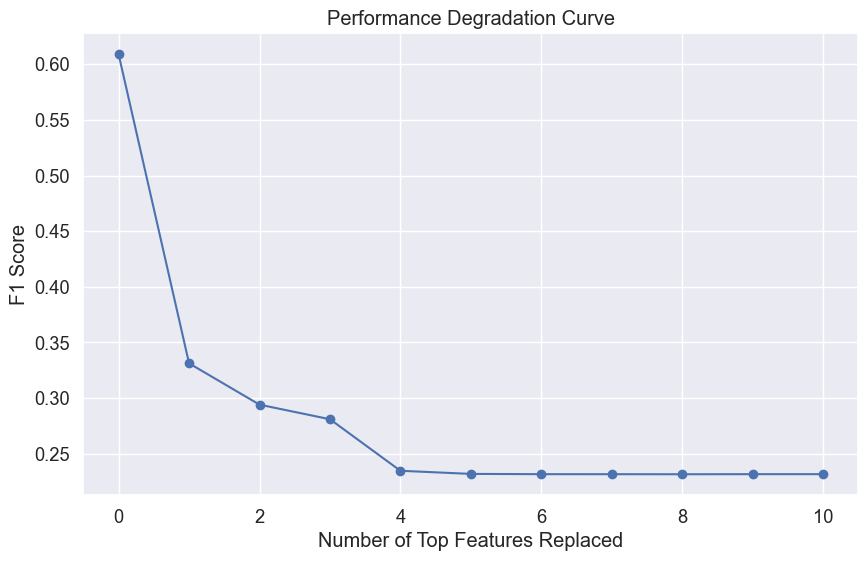

In [131]:
# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_rfc)), f1_scores_rfc, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(True)

### LIME
WIP
   Code inspired from following example: https://nbviewer.org/github/naiborhujosua/Blog_Notes/blob/main/notebook/interpreting-black-box-models.ipynb

In [42]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=sub_X_train,
    training_labels=sub_y_train,
    feature_names=rfc_feature_names,
    class_names=['3', '4','5'],
    mode='classification'
)

In [43]:
sub_X_test_df = pd.DataFrame(sub_X_test,columns=rfc_feature_names)

In [64]:
exp_lime = explainer_lime.explain_instance(
    data_row=sub_X_test_df.iloc[1], 
    predict_fn=base_rfc.predict_proba, 
    num_features=10
)

exp_lime.show_in_notebook(show_table=True)
exp_lime.save_to_file('base_rfc_lime_local.html')

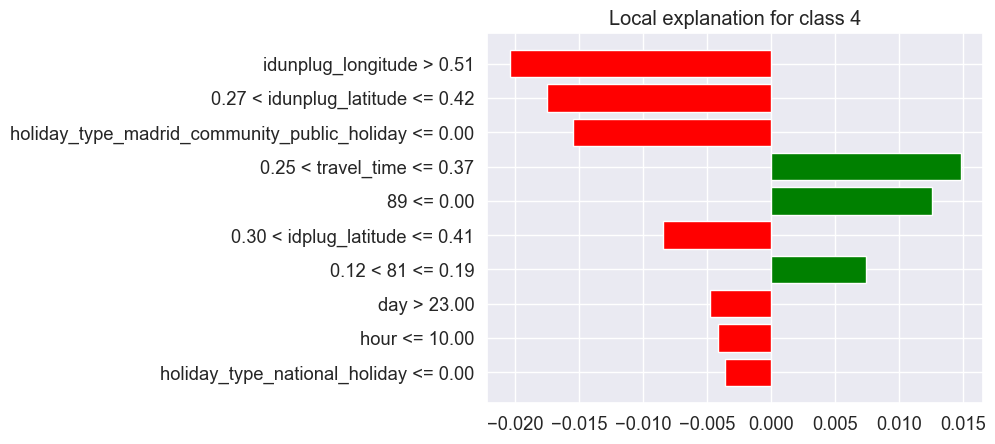

In [67]:
figure = exp_lime.as_pyplot_figure(label = exp_lime.available_labels()[0])

In [57]:
# Using SP-LIME to return explanations on a sample data set 
# to obtain a non-redundant global decision perspective of the base model
sp_exp_lime = submodular_pick.SubmodularPick(explainer_lime, 
                                        sub_X_test,
                                        predict_fn=base_rfc.predict_proba,
                                        num_features=5,
                                        num_exps_desired=5)

In [63]:
# Global Interpretability on subset instances
for i, exp in enumerate(sp_exp_lime.sp_explanations):
    # Plot results
    exp_lime.show_in_notebook()

    # Save the results as html
    file_name = f'base_rfc_global_lime_explanation_{i}.html'
    exp.save_to_file(file_name)
    print(f"Explanation saved to {file_name}")

print('SP-LIME Explanations for Base RFC.')


Explanation saved to base_rfc_global_lime_explanation_0.html


Explanation saved to base_rfc_global_lime_explanation_1.html


Explanation saved to base_rfc_global_lime_explanation_2.html


Explanation saved to base_rfc_global_lime_explanation_3.html


Explanation saved to base_rfc_global_lime_explanation_4.html
SP-LIME Explanations for Base RFC.


SP-LIME Local Explanations


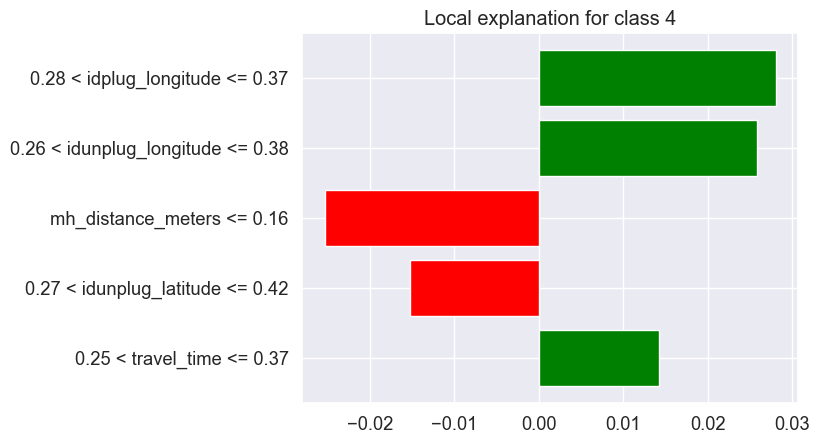

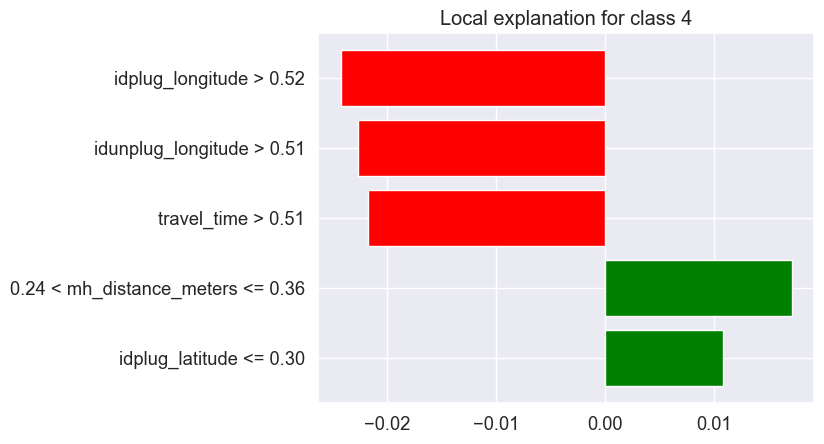

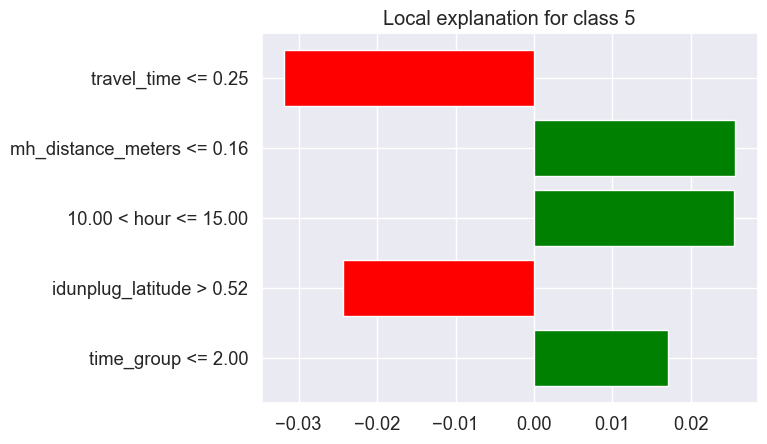

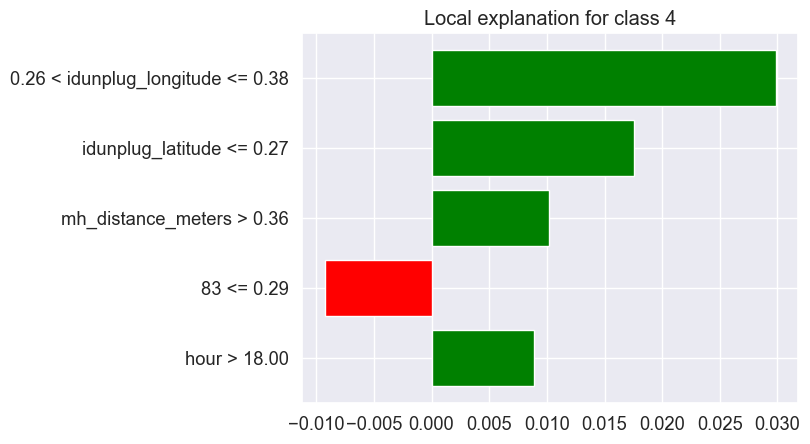

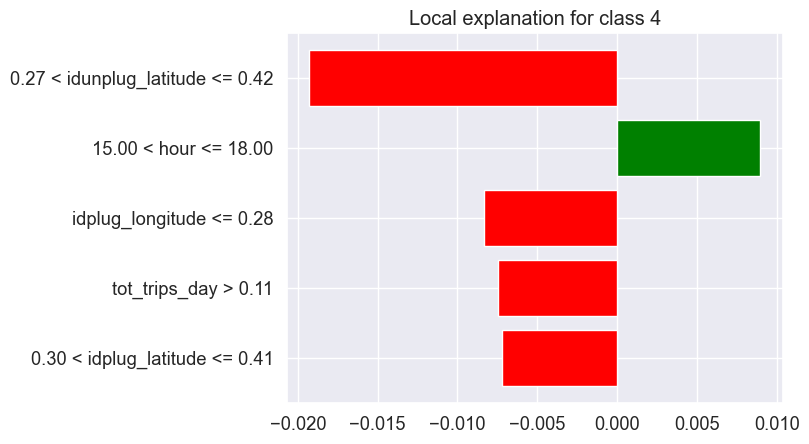

In [68]:
# Global Interpretability on subset instances
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_exp_lime.sp_explanations]
print('SP-LIME Local Explanations')

## Baseline XGBoost

### Baseline XGBC

In [41]:
numb_split = 5
rand_state = 123

# Define Base RandomForestClassifier model
base_xgbc_cv = xgb.XGBClassifier(random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda")

# Define the StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Measure traininig time
start_time = time.time()
base_xgbc_cv_results = cross_validate(base_xgbc_cv, X_train_trans, y_train_le, cv=stratified_kfold, scoring=f1_scorer, return_train_score=True, return_estimator=True)
end_time = time.time()
base_xgbc_train_time = end_time - start_time

In [ ]:
# Print the cross-validation training time and scores:
print(f"Base XGBC training time: {base_xgbc_train_time} seconds for K-fold: {numb_split}\n")

In [43]:
# Train performance
print(f"Base XGBC Cross-val Mean f1 macro train_score: {np.mean(base_xgbc_cv_results['train_score'])}")
print(f"Base XGBC Cross-val Standard Deviation of f1 macro train_score: {np.std(base_xgbc_cv_results['train_score'])}\n")

Base XGBC Cross-val Mean f1 macro train_score: 0.4345043295267719
Base XGBC Cross-val Standard Deviation of f1 macro train_score: 0.0010761339278808036



In [44]:
# Validation performance
print(f"Base XGBC Cross-val Mean f1 macro val_score: {np.mean(base_xgbc_cv_results['test_score'])}")
print(f"Base XGBC Cross-val Standard Deviation of f1 macro val_score: {np.std(base_xgbc_cv_results['test_score'])}")

Base XGBC Cross-val Mean f1 macro val_score: 0.4249418320256523
Base XGBC Cross-val Standard Deviation of f1 macro val_score: 0.002000740579316581


### Baseline XGBC Test performance

In [67]:
# Define Base RandomForestClassifier model
base_xgbc = xgb.XGBClassifier(random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda")

# Fit model with entire training dataset
base_xgbc.fit(X_train_trans,y_train_le)

# Make predictions on the test dataset
base_xgbc_prediction = base_xgbc.predict(X_test_trans)


Base XGBC f1 macro score: 0.4288420763457578

Base XGBC precision macro score: 0.6458694989277793

Base XGBC recall macro score: 0.43338306572332064

Base XGBC balanced accuracy score: 0.43338306572332064

Base XGBC accuracy score: 0.6062991506144073

Base XGBC cohen kappa score: 0.2229456189911896

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.06      0.11     36280
           1       0.60      0.87      0.71    202822
           2       0.62      0.37      0.46    141997

    accuracy                           0.61    381099
   macro avg       0.65      0.43      0.43    381099
weighted avg       0.62      0.61      0.56    381099




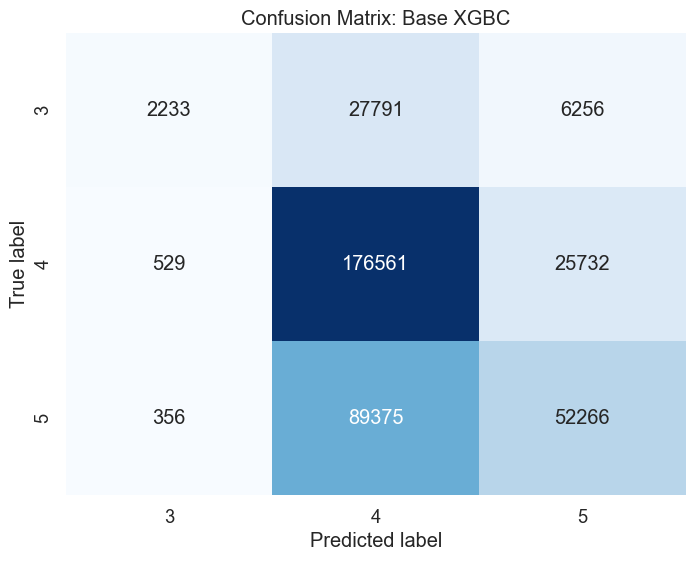

In [68]:
# Test performance
conf_matrix_classif_report("Base XGBC", y_test_le, base_xgbc_prediction)

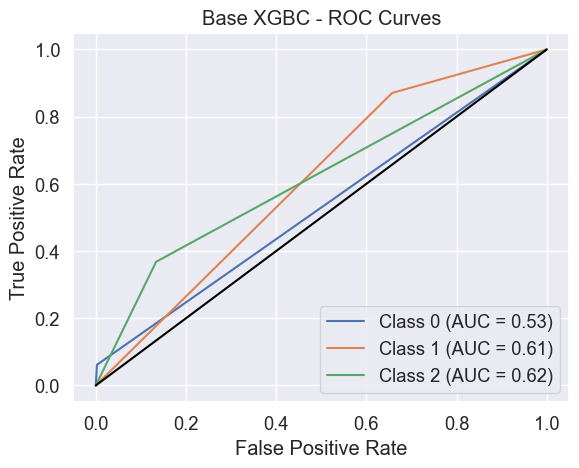

In [69]:
# Test performance
roc_curves("Base XGBC", y_train_le, y_test_le, base_xgbc_prediction) 

## Baseline LTCN
! WIP

In [40]:
# OneHotEncoding target variables
ltcn_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_ltcn = ltcn_ohe.fit_transform(y_train.reshape(-1, 1))
y_test_ltcn = ltcn_ohe.transform(y_test.reshape(-1, 1))
y_train_ltcn 
y_test_ltcn 

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
base_ltcn = LTCN(T=5, phi=0.9, method="ridge", function='sigmoid',alpha=1.0E-4)

In [42]:
base_ltcn.fit(X_train_trans,y_train_ltcn )

ltcn_test_prediction = base_ltcn.predict(X_test_trans)



LTCN(T=5, phi=0.9) f1 macro score: 0.2611955017239627

LTCN(T=5, phi=0.9) balanced accuracy score: 0.34026973959291346

LTCN(T=5, phi=0.9) accuracy score: 0.5351286673541521

LTCN(T=5, phi=0.9) cohen kappa score: 0.019130375650813547

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     36280
           1       0.54      0.97      0.69    202822
           2       0.49      0.05      0.09    141997

    accuracy                           0.54    381099
   macro avg       0.34      0.34      0.26    381099
weighted avg       0.47      0.54      0.40    381099




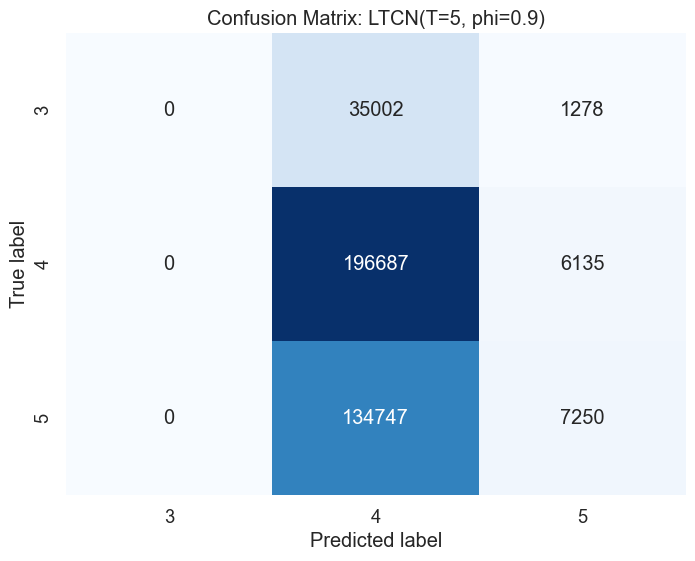

In [43]:
conf_matrix_classif_report(base_ltcn, np.argmax(y_test_ltcn, axis=1), np.argmax(ltcn_test_prediction, axis=1))

In [ ]:
ltcn_test_f1_score = f1_score(y_test_ltcn, ltcn_test_prediction, average=None)
print(f"Test F1 score base_xgb: {ltcn_test_f1_score}")
print(classification_report(y_test_ltcn, ltcn_test_prediction))

#### Base LTCN cross val
WIP

In [55]:
def f1_macro_scorer(Y,Y_pred):
    return f1_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1), average='macro')

In [ ]:
numb_split = 5
rand_state = 123

# Define Base RandomForestClassifier model
base_ltcn = LTCN(T=5, phi=0.9, method="ridge", function='sigmoid', alpha=1.0E-4)

# Define the StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Evaluate model with cross validation using F1 macro score
scoring = make_scorer(f1_macro_scorer)

# Measure traininig time
start_time = time.time()
base_ltcn_cv_results = cross_validate(base_ltcn, X_train_trans, y_train_ltcn, cv=stratified_kfold, scoring=f1_scorer, return_train_score=True, return_estimator=True)
end_time = time.time()
base_ltcn_train_time = end_time - start_time

In [57]:
import random
import os

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

In [ ]:
numb_split = 5

reset_random_seeds()

train_errors = []
test_errors = []
        
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=42)
skf.get_n_splits(X_train_trans, y_train_ltcn)

for train_index, test_index in skf.split(X_train_trans, y_train_ltcn):
    
    X_train, X_test = X_train_trans[train_index], X_train_trans[test_index]
    Y_train, Y_test = y_train_ltcn[train_index], y_train_ltcn[test_index]

    model = LTCN(method='inverse')

    # hyper-parameter tuning using grid search happens here!!
    param_grid = {'function': ['sigmoid', 'tanh'], 'phi': [0.8, 0.9, 1],
                    'T': [5, 10, 15]} #  'alpha': [0, 1.0E-2, 1.0E+2]

    score_f1_macro = make_scorer(f1_macro_scorer)
    grid_clf = GridSearchCV(model, param_grid, scoring=score_f1_macro, cv=numb_split, n_jobs=-1, error_score='raise')
    grid_clf.fit(X_train, Y_train)
    
    Y_pred_train = grid_clf.predict(X_train)
    train_errors.append(f1_macro_scorer(np.argmax(Y_train, axis=1), np.argmax(Y_pred_train, axis=1)))
    
    Y_pred_test = grid_clf.predict(X_test)
    test_errors.append(f1_macro_scorer(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1)))

train_score = sum(train_errors) / len(train_errors)
test_score = sum(test_errors) / len(test_errors)

In [ ]:
import itertools
import numpy as np

def stratified_grid_search(classifier, param_grid, X, y, cv=5):
    best_score = -np.inf
    best_params = None

    # Generate all parameter combinations
    param_combinations = list(itertools.product(*param_grid.values()))

    # Calculate the number of samples in each class
    class_counts = {}
    for label in set(y):
        class_counts[label] = sum(1 for y_i in y if y_i == label)

    # Perform stratified sampling for each parameter combination
    for params in param_combinations:
        scores = []

        for train_idx, val_idx in stratified_k_fold_cv(X, y, cv):
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            classifier.set_params(**dict(zip(param_grid.keys(), params)))
            classifier.fit(X_train, y_train)
            score = classifier.score(X_val, y_val)
            scores.append(score)

        # Calculate the mean score across all folds
        mean_score = np.mean(scores)

        # Update best score and parameters if current combination performs better
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    return best_params

def stratified_k_fold_cv(X, y, k=5):
    n_samples = len(y)
    fold_sizes = (n_samples // k) * np.ones(k, dtype=np.int)
    fold_sizes[:n_samples % k] += 1

    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = np.arange(start, stop)
        train_idx = np.concatenate([np.arange(0, start), np.arange(stop, n_samples)])
        yield train_idx, val_idx
        current = stop

# Example usage:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define the parameter grid
param_grid = {'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance']}

# Initialize the classifier
classifier = KNeighborsClassifier()

# Perform stratified grid search
best_params = stratified_grid_search(classifier, param_grid, X, y)

print("Best parameters:", best_params)